In [1]:
import cptac
import scipy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from venn import venn
import numpy as np
import math
import pandas as pd
import statistics
import cptac.utils as ut
from functools import reduce

In [2]:
cptac.download("brca")
cptac.download("ccrcc")
cptac.download("colon")
cptac.download("endometrial")
cptac.download("gbm")
cptac.download("luad")
cptac.download("ovarian")
cptac.download("hnscc")
cptac.download("lscc")

brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 15)


cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 16)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 18)


version 3scc v3.2.......                 


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 19)


In [3]:
def get_gene_list(tissue):
    #Returns a list of the genes that are in both proteomics and transcriptomics
    gene_list = []
    prot = tissue.get_proteomics()
    if isinstance(prot.columns, pd.MultiIndex):
        prot = prot.columns.get_level_values(0)
    trans = tissue.get_transcriptomics()
    if isinstance(trans.columns, pd.MultiIndex):
        trans = trans.columns.get_level_values(0)
    for i in prot:
        if i in trans and i not in gene_list:
            gene_list.append(i)
    return gene_list


In [4]:
def fill_genes_nan(all_genes, tissue_corr):
    tissue_genes = []
    for i, j  in tissue_corr:
        tissue_genes.append(i)
        
    for i in all_genes:
        if i not in tissue_genes:
            tissue_corr.append([i, np.nan])
    end_list = sorted(tissue_corr)
           
    return end_list

In [5]:

def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both"):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = cptac.utils.reduce_multiindex(prot, levels_to_drop = "Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = cptac.utils.reduce_multiindex(trans, levels_to_drop = "Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
        
    for gene in gene_list:
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list

In [6]:
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li

In [7]:
def find_around_015 (prep):
    genes = []
    keys = prep.keys()
    for i in keys:
        if prep[i]  <= 0.15 and prep[i] >= -0.15:
            genes.append(i)
    return genes

In [8]:
def Intersection(lst1, lst2): 
    return set(lst1).intersection(lst2) 

In [9]:
def minmax(val_list):
    if len(val_list) == 0:
        return np.nan, np.nan
    else:
        min_val = min(val_list)
        max_val = max(val_list)

    return (min_val, max_val)

In [10]:
brca_gene_list = get_gene_list(brca)
ccrcc_gene_list = get_gene_list(ccrcc)
colon_gene_list = get_gene_list(colon)
gbm_gene_list = get_gene_list(gbm)
luad_gene_list = get_gene_list(luad)
ovarian_gene_list = get_gene_list(ovarian)
en_gene_list = get_gene_list(en)
hnscc_gene_list = get_gene_list(hnscc)
lscc_gene_list = get_gene_list(lscc)

In [11]:
brca_corr, brca_pval = correlation_list(brca, brca_gene_list, tissue_type = "tumor")
ccrcc_corr, ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list, tissue_type = "tumor")
colon_corr, colon_pval = correlation_list(colon, colon_gene_list, tissue_type = "tumor")
en_corr, en_pval = correlation_list(en, en_gene_list, tissue_type = "tumor")
gbm_corr, gbm_pval = correlation_list(gbm, gbm_gene_list, tissue_type = "tumor")
luad_corr, luad_pval = correlation_list(luad,luad_gene_list, tissue_type = "tumor")
ovarian_corr, ovarian_pval = correlation_list(ovarian, ovarian_gene_list, tissue_type = "tumor")
hnscc_corr, hnscc_pval = correlation_list(hnscc, hnscc_gene_list, tissue_type = "tumor")
lscc_corr, lscc_pval = correlation_list(lscc, lscc_gene_list, tissue_type = "tumor")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now

In [12]:
normal_brca_corr, normal_brca_pval = correlation_list(brca, brca_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ccrcc_corr, normal_ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_colon_corr, normal_colon_pval = correlation_list(colon, colon_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_en_corr, normal_en_pval = correlation_list(en, en_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_gbm_corr, normal_gbm_pval = correlation_list(gbm, gbm_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_luad_corr, normal_luad_pval = correlation_list(luad,luad_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ovarian_corr, normal_ovarian_pval = correlation_list(ovarian, ovarian_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_hnscc_corr, normal_hnscc_pval = correlation_list(hnscc, hnscc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_lscc_corr, normal_lscc_pval = correlation_list(lscc, lscc_gene_list,valid_sample_number = 7, tissue_type="normal")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (C:\U

In [13]:
genes = brca_gene_list + ccrcc_gene_list + colon_gene_list + en_gene_list + gbm_gene_list+ luad_gene_list + ovarian_gene_list + hnscc_gene_list + lscc_gene_list
common_genes = []
for i in genes:
    if i not in common_genes:
        common_genes.append(i)
common_genes = sorted(common_genes)

In [14]:
##Getting tumor correlations

brca_list_corr = ret_list(fill_genes_nan(common_genes, brca_corr))
ccrcc_list_corr = ret_list(fill_genes_nan(common_genes, ccrcc_corr))
colon_list_corr = ret_list(fill_genes_nan(common_genes, colon_corr))
en_list_corr = ret_list(fill_genes_nan(common_genes, en_corr))
gbm_list_corr = ret_list(fill_genes_nan(common_genes, gbm_corr))
luad_list_corr = ret_list(fill_genes_nan(common_genes, luad_corr))
ovarian_list_corr = ret_list(fill_genes_nan(common_genes, ovarian_corr))
hnscc_list_corr = ret_list(fill_genes_nan(common_genes, hnscc_corr))
lscc_list_corr = ret_list(fill_genes_nan(common_genes, lscc_corr))

median_list = []
std_list = []
sigma_list = []
range_list = []
tissue_row = []


for i in range(len(common_genes)):

    row = list(filter(lambda x:not math.isnan(x),[brca_list_corr[i], ccrcc_list_corr[i], colon_list_corr[i], 
             en_list_corr[i],gbm_list_corr[i],luad_list_corr[i],ovarian_list_corr[i],
             hnscc_list_corr[i],lscc_list_corr[i]]))#Creates a list without Nan on each row


    tissue_row.append(len(row))
    if len(row) == 0:
        list_median = np.nan
    else:
        list_median = statistics.median(row)
    median_list.append(list_median)
    
    ###Standard Deviation calculation
    std = 0
    if len(row) < 2:
        std = np.nan    
    else:
        std = statistics.stdev(row)
    std_list.append(std)
    
    ### 3 sigma calculation
    neg_sigma = list_median - 2.8 * std
    pos_sigma = list_median + 2.8 * std
    
    for i in row:
        sigma_bool = False
        if i > pos_sigma or i < neg_sigma:
            sigma_bool = True
            break
    sigma_list.append(sigma_bool)
    
    ###Calculating range
    min_value, max_value = minmax(row)
    range_list.append(max_value - min_value)
    
    
correlation_columns = {'BRCA': (brca_list_corr),'CCRCC': (ccrcc_list_corr), 
       'Colon': (colon_list_corr), 'Endometrial': (en_list_corr),
       'GBM': (gbm_list_corr), 'LUAD': (luad_list_corr), 'Ovarian': (ovarian_list_corr),
        'HNSCC' : (hnscc_list_corr), 'LSCC' : (lscc_list_corr), 'Median' : median_list, 'Stnd Deviation' :std_list, '+/- 3 sigma' : sigma_list, 'Range' : range_list , 'Tissue_Sample_number': tissue_row}

correlation_df = pd.DataFrame(correlation_columns , columns = ['BRCA', 'CCRCC', 'Colon', 'Endometrial', 'GBM', 'LUAD', 'Ovarian', 'HNSCC', 'LSCC', 'Median', 'Stnd Deviation', '+/- 3 sigma', 'Range','Tissue_Sample_number'], index=common_genes)
correlation_df.head()

,BRCA,CCRCC,Colon,Endometrial,GBM,LUAD,Ovarian,HNSCC,LSCC,Median,Stnd Deviation,+/- 3 sigma,Range,Tissue_Sample_number
A1BG,0.131286,-0.059781,NaN,0.386703,-0.200579,-0.067920,NaN,0.112133,0.122072,0.112133,0.190174,False,0.587282,7
A1CF,NaN,0.892757,0.698025,NaN,NaN,NaN,NaN,NaN,NaN,0.795391,0.137696,False,0.194732,2
A2M,0.422497,0.010289,-0.122255,0.024022,0.312922,0.381025,0.140341,0.201083,0.345069,0.201083,0.190275,False,0.544752,9
A2ML1,0.713289,NaN,NaN,0.835080,NaN,NaN,0.531368,0.862612,0.832191,0.832191,0.137571,False,0.331245,5
A4GALT,NaN,NaN,NaN,0.486499,NaN,NaN,NaN,NaN,0.312484,0.399491,0.123047,False,0.174015,2


In [15]:
##Getting normal correlations

normal_brca_list_corr = ret_list(fill_genes_nan(common_genes, normal_brca_corr))
normal_ccrcc_list_corr = ret_list(fill_genes_nan(common_genes, normal_ccrcc_corr))
normal_colon_list_corr = ret_list(fill_genes_nan(common_genes, normal_colon_corr))
normal_en_list_corr = ret_list(fill_genes_nan(common_genes, normal_en_corr))
normal_gbm_list_corr = ret_list(fill_genes_nan(common_genes, normal_gbm_corr))
normal_luad_list_corr = ret_list(fill_genes_nan(common_genes, normal_luad_corr))
normal_ovarian_list_corr = ret_list(fill_genes_nan(common_genes, normal_ovarian_corr))
normal_hnscc_list_corr = ret_list(fill_genes_nan(common_genes, normal_hnscc_corr))
normal_lscc_list_corr = ret_list(fill_genes_nan(common_genes, normal_lscc_corr))

median_list = []
std_list = []
sigma_list = []
range_list = []
tissue_row = []


for i in range(len(common_genes)):

    row = list(filter(lambda x:not math.isnan(x),[normal_brca_list_corr[i], normal_ccrcc_list_corr[i], normal_colon_list_corr[i], 
             normal_en_list_corr[i],normal_gbm_list_corr[i],normal_luad_list_corr[i],normal_ovarian_list_corr[i],
             normal_hnscc_list_corr[i],normal_lscc_list_corr[i]]))#Creates a list without Nan on each row


    tissue_row.append(len(row))
    if len(row) == 0:
        list_median = np.nan
    else:
        list_median = statistics.median(row)
    median_list.append(list_median)
    
    ###Standard Deviation calculation
    std = 0
    if len(row) < 2:
        std = np.nan    
    else:
        std = statistics.stdev(row)
    std_list.append(std)
    
    ### 3 sigma calculation
    neg_sigma = list_median - 2.8 * std
    pos_sigma = list_median + 2.8 * std
    
    for i in row:
        sigma_bool = False
        if i > pos_sigma or i < neg_sigma:
            sigma_bool = True
            break
    sigma_list.append(sigma_bool)
    
    ###Calculating range
    min_value, max_value = minmax(row)
    range_list.append(max_value - min_value)
    
    
normal_correlation_columns = {'BRCA': (normal_brca_list_corr),'CCRCC': (normal_ccrcc_list_corr), 
       'Colon': (normal_colon_list_corr), 'Endometrial': (normal_en_list_corr),
       'GBM': (normal_gbm_list_corr), 'LUAD': (normal_luad_list_corr), 'Ovarian': (normal_ovarian_list_corr),
        'HNSCC' : (normal_hnscc_list_corr), 'LSCC' : (normal_lscc_list_corr), 'Median' : median_list, 'Stnd Deviation' :std_list, '+/- 3 sigma' : sigma_list, 'Range' : range_list , 'Tissue_Sample_number': tissue_row}

normal_correlation_df = pd.DataFrame(normal_correlation_columns , columns = ['BRCA', 'CCRCC', 'Colon', 'Endometrial', 'GBM', 'LUAD', 'Ovarian', 'HNSCC', 'LSCC', 'Median', 'Stnd Deviation', '+/- 3 sigma', 'Range','Tissue_Sample_number'], index=common_genes)
normal_correlation_df.head()

,BRCA,CCRCC,Colon,Endometrial,GBM,LUAD,Ovarian,HNSCC,LSCC,Median,Stnd Deviation,+/- 3 sigma,Range,Tissue_Sample_number
A1BG,NaN,0.328964,NaN,0.325049,0.096352,-0.028771,NaN,0.114784,-0.074874,0.105568,0.170950,False,0.403839,6
A1CF,NaN,0.745763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.745763,NaN,False,0.000000,1
A2M,NaN,0.287323,NaN,0.049557,0.290741,0.283792,NaN,0.395269,0.407699,0.289032,0.128596,False,0.358142,6
A2ML1,NaN,NaN,NaN,0.432870,NaN,NaN,NaN,0.744775,0.183068,0.432870,0.281425,False,0.561706,3
A4GALT,NaN,NaN,NaN,0.087438,NaN,NaN,NaN,0.149814,0.065653,0.087438,0.043682,False,0.084162,3


BRCA, Colon and Ovarian have no normal data

In [16]:
##Filtering tissues that are usable
ccrcc_tissue = pd.DataFrame(correlation_df['CCRCC'])
en_tissue = pd.DataFrame(correlation_df['Endometrial'])
gbm_tissue = pd.DataFrame(correlation_df['GBM'])
luad_tissue = pd.DataFrame(correlation_df['LUAD'])
hnscc_tissue = pd.DataFrame(correlation_df['HNSCC'])
lscc_tissue = pd.DataFrame(correlation_df['LSCC'])

tissue_list = [ccrcc_tissue,en_tissue,gbm_tissue,luad_tissue,hnscc_tissue,lscc_tissue]
valid_tissue = en._join_dataframe('outer', tissue_list[0])
valid_tissue = en._join_dataframe(valid_tissue, tissue_list[1])
valid_tissue = en._join_dataframe(valid_tissue, tissue_list[3])
valid_tissue = en._join_dataframe(valid_tissue, tissue_list[4])
valid_tissue = en._join_dataframe(valid_tissue, tissue_list[5])

In [17]:
##Filtering tissues that are usable
normal_ccrcc_tissue = pd.DataFrame(normal_correlation_df['CCRCC'])
normal_en_tissue = pd.DataFrame(normal_correlation_df['Endometrial'])
normal_gbm_tissue = pd.DataFrame(normal_correlation_df['GBM'])
normal_luad_tissue = pd.DataFrame(normal_correlation_df['LUAD'])
normal_hnscc_tissue = pd.DataFrame(normal_correlation_df['HNSCC'])
normal_lscc_tissue = pd.DataFrame(normal_correlation_df['LSCC'])

normal_tissue_list = [normal_ccrcc_tissue,normal_en_tissue,normal_gbm_tissue,normal_luad_tissue,normal_hnscc_tissue,normal_lscc_tissue]
normal_valid_tissue = en._join_dataframe('outer', normal_tissue_list[0])
normal_valid_tissue = en._join_dataframe(normal_valid_tissue, normal_tissue_list[1])
normal_valid_tissue = en._join_dataframe(normal_valid_tissue, normal_tissue_list[3])
normal_valid_tissue = en._join_dataframe(normal_valid_tissue, normal_tissue_list[4])
normal_valid_tissue = en._join_dataframe(normal_valid_tissue, normal_tissue_list[5])

In [18]:
valid_tissue = valid_tissue[0]
valid_tissue

,CCRCC,Endometrial,LUAD,HNSCC,LSCC
A1BG,-0.059781,0.386703,-0.067920,0.112133,0.122072
A1CF,0.892757,NaN,NaN,NaN,NaN
A2M,0.010289,0.024022,0.381025,0.201083,0.345069
A2ML1,NaN,0.835080,NaN,0.862612,0.832191
A4GALT,NaN,0.486499,NaN,NaN,0.312484
...,...,...,...,...,...
ZXDC,0.124010,0.146719,0.212842,0.488809,0.600445
ZYG11B,0.241315,0.231203,0.556451,0.324304,0.363366
ZYX,0.217698,0.532447,0.414920,0.544006,0.541382
ZZEF1,0.197289,0.299816,0.679603,0.555744,0.625155


In [19]:
normal_valid_tissue = normal_valid_tissue[0]
normal_valid_tissue

,CCRCC,Endometrial,LUAD,HNSCC,LSCC
A1BG,0.328964,0.325049,-0.028771,0.114784,-0.074874
A1CF,0.745763,NaN,NaN,NaN,NaN
A2M,0.287323,0.049557,0.283792,0.395269,0.407699
A2ML1,NaN,0.432870,NaN,0.744775,0.183068
A4GALT,NaN,0.087438,NaN,0.149814,0.065653
...,...,...,...,...,...
ZXDC,-0.213461,0.413797,0.125048,-0.103032,0.268095
ZYG11B,0.131901,-0.169069,-0.151540,0.777574,0.132199
ZYX,0.441631,0.385142,-0.057218,0.554678,0.225703
ZZEF1,0.335641,-0.067975,0.261014,0.300239,0.356916


In [20]:
for i in normal_valid_tissue:
    normal_valid_tissue = normal_valid_tissue.rename(columns={i: str(i)+'_normal'})

In [21]:
normal_valid_tissue

,CCRCC_normal,Endometrial_normal,LUAD_normal,HNSCC_normal,LSCC_normal
A1BG,0.328964,0.325049,-0.028771,0.114784,-0.074874
A1CF,0.745763,NaN,NaN,NaN,NaN
A2M,0.287323,0.049557,0.283792,0.395269,0.407699
A2ML1,NaN,0.432870,NaN,0.744775,0.183068
A4GALT,NaN,0.087438,NaN,0.149814,0.065653
...,...,...,...,...,...
ZXDC,-0.213461,0.413797,0.125048,-0.103032,0.268095
ZYG11B,0.131901,-0.169069,-0.151540,0.777574,0.132199
ZYX,0.441631,0.385142,-0.057218,0.554678,0.225703
ZZEF1,0.335641,-0.067975,0.261014,0.300239,0.356916


In [22]:
##Substracting correlations to get behavior of genes 
ccrcc_prep = (valid_tissue['CCRCC']-normal_valid_tissue['CCRCC_normal'])
en_prep = (valid_tissue['Endometrial']-normal_valid_tissue['Endometrial_normal'])
luad_prep = (valid_tissue['LUAD']-normal_valid_tissue['LUAD_normal'])
hnscc_prep = (valid_tissue['HNSCC']-normal_valid_tissue['HNSCC_normal'])
lscc_prep = (valid_tissue['LSCC']-normal_valid_tissue['LSCC_normal'])

In [23]:
##Finding genes that their behavior falls between -0.15 and 0.15
ccrcc_v015 = find_around_015(ccrcc_prep)
en_v015 = find_around_015(en_prep)
luad_v015 =find_around_015(luad_prep)
hnscc_v015 = find_around_015(hnscc_prep)
lscc_v015 = find_around_015(lscc_prep)

In [24]:
ccrcc_set = set(ccrcc_v015)
en_set = set(en_v015)
luad_set = set(luad_v015)
hnscc_set = set(hnscc_v015)
lscc_set = set(lscc_v015)

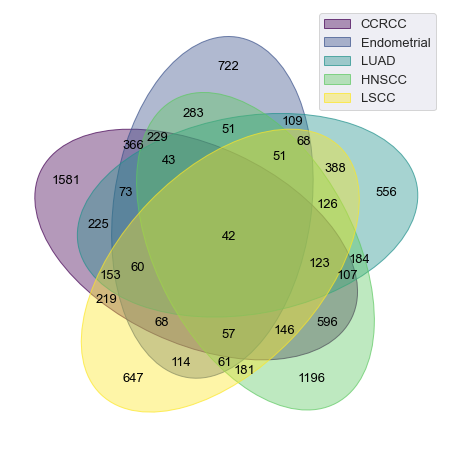

In [25]:
##Getting Venn diagram
dataset_dict = { 'CCRCC' : ccrcc_set, 'Endometrial': en_set, 'LUAD' : luad_set, 'HNSCC' : hnscc_set, 'LSCC' : lscc_set}
venn(dataset_dict)


In [26]:
##Getting the genes that are in 4 out of 5 tissues

abcd_list = (Intersection(ccrcc_v015,en_v015))
abcd_list = (Intersection(list(abcd_list),luad_v015))
abcd_list = (Intersection(list(abcd_list),hnscc_v015))

abce_list = (Intersection(ccrcc_v015,en_v015))
abce_list = (Intersection(list(abce_list),luad_v015))
abce_list = (Intersection(list(abce_list),lscc_v015))

acde_list = (Intersection(ccrcc_v015,luad_v015))
acde_list = (Intersection(list(acde_list),hnscc_v015))
acde_list = (Intersection(list(acde_list),lscc_v015))

abde_list = (Intersection(ccrcc_v015,en_v015))
abde_list = (Intersection(list(abde_list),hnscc_v015))
abde_list = (Intersection(list(abde_list),lscc_v015))

bcde_list = (Intersection(en_v015,luad_v015))
bcde_list = (Intersection(list(bcde_list),hnscc_v015))
bcde_list = (Intersection(list(bcde_list),lscc_v015))

In [27]:
list_4_5 = []
for i in abcd_list:
    if i not in list_4_5:
        list_4_5.append(i)
        
for i in abce_list:
    if i not in list_4_5:
        list_4_5.append(i)
    
for i in abde_list:
    if i not in list_4_5:
        list_4_5.append(i)
        
for i in acde_list:
    if i not in list_4_5:
        list_4_5.append(i)
        
for i in bcde_list:
    if i not in list_4_5:
        list_4_5.append(i)

In [28]:
len(list_4_5)

376